<!-- ---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
--- -->
# Gradient Considerations

In [1]:
import autoroot

In [2]:
import xarray as xr

xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_obs_nadir.nc")
xrds

<xarray.Dataset>
Dimensions:      (lat: 201, lon: 201, time: 365)
Coordinates:
  * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time         (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    mask         (lat, lon) float64 ...
    lag          (time, lat, lon) float64 ...
    flag         (time, lat, lon) float64 ...
    ssh_obs      (time, lat, lon) float64 ...
    ssh_mod      (time, lat, lon) float64 ...
    anomaly_obs  (time, lat, lon) float64 ...
    anomaly_mod  (time, lat, lon) float64 ...

In [ ]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [ ]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [ ]:
from pathlib import Path

In [ ]:
Path(
    "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
).is_file()

In [5]:
!ls configs
!pwd

eval_natl60_dc20a.yaml	natl60_obs.yaml   results_dc20a_nadir.yaml
lr_scheduler.yaml	natl60.yaml	  results_dc20a_swot.yaml
metrics.yaml		optimizer.yaml
model.yaml		postprocess.yaml
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/notebooks/dev/nerfs


In [6]:
!cat configs/natl60.yaml

natl60_dc20a:
    _target_: jejeqx._src.datamodules.coords_v2.AlongTrackDM
    paths: "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    batch_size: 10_000
    shuffle: True
    train_size: 0.80
    subset_size: 0.40
    spatial_coords: ["lat", "lon"]
    temporal_coords: ["time"]
    variables: ["ssh"]
    evaluation: False
    resample: "1D"
    decode_times: False
    spatial_units: "meters"
    time_unit: "seconds"
    time_freq: 1
    t0: "2013-01-01"
    select: 
        time: {_target_: builtins.slice, _args_: ["2013-01-01", "2013-01-01"]}
        
        
natl60_dc20a_scaled:
    _target_: jejeqx._src.datamodules.coords_v2.AlongTrackDM
    paths: "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    batch_size: 10_000
    shuffle: True
    train_size: 0.80
    subset_size: 0.40
    spatial_coords: ["lat", "lon"]
    temporal_coords: ["time"]
    variables: ["ssh"]
    evaluation:

In [7]:
# !cat configs/natl60.yaml

In [8]:
# load config
config_dm = OmegaConf.load('/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/notebooks/dev/nerfs/configs/natl60.yaml')

# instantiate
dm = hydra.utils.instantiate(config_dm.natl60_dc20a)

# run setup
dm.setup()

# check cunits
(
    dm.ds_test[:]["spatial"].min(),
    dm.ds_test[:]["spatial"].max(),
    dm.ds_test[:]["temporal"].min(),
    dm.ds_test[:]["temporal"].max(),
    dm.ds_test[:]["data"].min(),
    dm.ds_test[:]["data"].max(),
)

(0.0, 1111948.7428468189, 0.0, 0.0, -0.46802905337971806, 1.0029388256616805)

In [9]:
# spatial transform
spatial_transforms = hydra.utils.instantiate(config_dm.spatial_transforms)
spatial_transforms

temporal_transforms = hydra.utils.instantiate(config_dm.temporal_transforms)
temporal_transforms

Pipeline(steps=[('timeminmax', MinMaxDF(columns=['time']))])

In [10]:


# instantiate
dm = hydra.utils.instantiate(
    config_dm.natl60_dc20a_scaled,
)

# run setup
dm.setup()

# check units
(
    dm.ds_test[:]["spatial"].min(),
    dm.ds_test[:]["spatial"].max(),
    dm.ds_test[:]["temporal"].min(),
    dm.ds_test[:]["temporal"].max(),
    dm.ds_test[:]["data"].min(),
    dm.ds_test[:]["data"].max(),
)

(-1.0, 1.0, -1.0, -1.0, -0.46802905337971806, 1.0029388256616805)

In [11]:
len(dm.ds_train)

12928

In [12]:
xrda = dm.load_xrds()

In [13]:
print(f"Field Shape: {xrda.ssh.shape}")
print(f"Number of Coords: {len(dm.ds_train):,}")

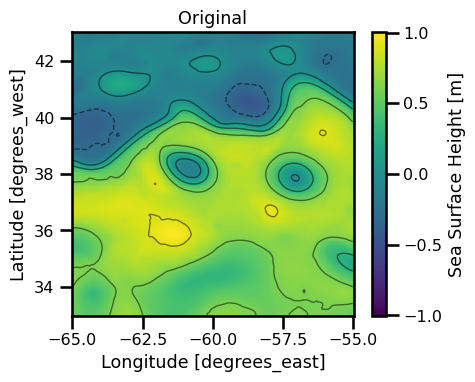

In [14]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=1, figsize=(5,4))

subset_ds = xrda.ssh.isel(time=0)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax, cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrda.ssh.min().values, xrda.ssh.max().values)
subset_ds.plot.contour(
    ax=ax, 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [15]:
init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

(-0.98, 1.0, (32, 2), -1.0, -1.0, (32, 1))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [16]:
!cat ./configs/model.yaml

In [17]:
# load config
model_config = OmegaConf.load("./configs/model.yaml")

# instantiate
model_mlp = hydra.utils.instantiate(model_config.mlp)

# test output
out = model_mlp(x=x_init[0], t=t_init[0])
assert out.shape == y_init[0].shape

# test output (batched)
out_batch = jax.vmap(model_mlp, in_axes=(0, 0))(x_init, t_init)
assert out_batch.shape == y_init.shape

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `2_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [18]:
import optax

num_epochs = 5000

# load config
opt_config = OmegaConf.load("./configs/optimizer.yaml")

# instantiate
optimizer = hydra.utils.instantiate(opt_config.adamw)

In [19]:
scheduler_config = OmegaConf.load("./configs/lr_scheduler.yaml")

num_steps_per_epoch = len(dm.ds_train)

scheduler = hydra.utils.instantiate(
    scheduler_config.warmup_cosine, decay_steps=int(num_epochs * num_steps_per_epoch)
)

optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

In [20]:
optimizer

GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x15529cf904c0>, update=<function chain.<locals>.update_fn at 0x15529cf90160>)

In [147]:
def fft_mse_1D(y, yhat, flow=None, fhigh=None, reduction: str="mean"):
    dims = y.shape
    
    # FFT Transformation
    y_f = jnp.fft.fftn(y)
    yhat_f = jnp.fft.fftn(yhat)
    print(y_f.shape[0])
    
    if flow is None:
        flow = 0
    if fhigh is None:
        fhigh = jnp.max(y_f.shape[0])-1
    
    # # Subset the 
    # if len(dims) == 1:
    #     print("here")
    #     y_f = y_f[flow:fhigh]
    #     # y_f = y_f[slice(flow,fhigh,1)]
    #     y_f = jax.lax.dynamic_slice_in_dim(y_f, start_index=flow, slice_size=fhigh-flow)
    #     # yhat_f = yhat_f[slice(flow,fhigh,1)]
    #     # yhat_f = yhat_f[flow:fhigh]
    #     yhat_f = jax.lax.dynamic_slice_in_dim(yhat_f, start_index=flow, slice_size=fhigh-flow)
    # elif len(dims) == 2:
    #     # y_f = y_f[flow:fhigh, flow:fhigh]
    #     # y_f = jax.lax.dynamic_slice_in_dim(y_f, start_index=[flow,flow], slice_size=[fhigh-flow,fhigh-flow])
    #     y_f = y_f[slice(flow,fhigh,1),slice(flow,fhigh,1)]
    #     # yhat_f = yhat_f[flow:fhigh, flow:fhigh]
    #     # yhat_f = jax.lax.dynamic_slice_in_dim(yhat_f, start_index=[flow,flow], slice_size=[fhigh-flow,fhigh-flow])
    #     yhat_f = yhat_f[slice(flow,fhigh,1),slice(flow,fhigh,1)]
    # elif len(dims) == 3:
    #     y_f = y_f[flow:fhigh, flow:fhigh, flow:fhigh]
    #     yhat_f = yhat_f[flow:fhigh, flow:fhigh, flow:fhigh]
    # elif len(dims) == 4:
    #     y_f = y_f[flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh]
    #     yhat_f = yhat_f[flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh]
    # elif len(dims) == 5:
    #     y_f = y_f[flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh]
    #     yhat_f = yhat_f[flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh, flow:fhigh]
    # else:
    #     raise ValueError(f"")
        
    if reduction == "mean":
        return jnp.abs(jnp.mean(y_f - yhat_f))
    elif reduction == "sum":
        return jnp.abs(jnp.sum(y_f - yhat_f))
    else:
        return jnp.abs(y_f - yhat_f)

## Trainer Module

In [148]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self, model, optimizer, **kwargs):
        super().__init__(model=model, optimizer=optimizer, pl_logger=None, **kwargs)

    def create_functions(self):
        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model, in_axes=(0, 0))(x, t)
            loss = jnp.mean((y - pred) ** 2)
            return loss
        
        def fft_mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model, in_axes=(0,0))(x, t)
            loss = fft_mse_1D(y=y, yhat=pred)
            return loss
        
        def train_step(state, batch):
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            fft_loss = fft_mse_loss(state.params, batch)
            metrics = {"loss": loss, "psnr": psnr_loss, "fft": fft_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return {"loss": loss, "psnr": psnr_loss}

        def test_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            out = jax.vmap(model, in_axes=(0, 0))(x, t)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            fft_loss = fft_mse_loss(model, batch)
            metrics = {"loss": loss, "psnr": psnr_loss, "fft": fft_loss}
            return out, metrics
        
        def predict_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            out = jax.vmap(model, in_axes=(0, 0))(x, t)
            return out

        return train_step, eval_step, test_step, predict_step

    def on_training_end(
        self,
    ):
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")

In [151]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model_mlp,
    optimizer,
    seed=seed,
    debug=debug,
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir,
)
train_more = False


In [152]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

10000
401
CPU times: user 762 ms, sys: 7.84 ms, total: 770 ms
Wall time: 643 ms


{'fft': 0.48898881673812866,
 'loss': 0.33336636424064636,
 'psnr': 8.517776489257812}

In [153]:
xrda["ssh_pre"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [154]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")
except:
    pass

In [155]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 281 ms, sys: 11.2 ms, total: 292 ms
Wall time: 194 ms


{'fft': 0.007226995658129454,
 'loss': 0.00013177159416954964,
 'psnr': 82.71487426757812}

In [156]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 21.9 µs


In [157]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_mlp_ssh.ckpt")
    # trainer.save_model("./checkpoints/checkpoint_model_gabor_ssh.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [158]:
out, metrics = trainer.test_model(dm.test_dataloader())
metrics

{'fft': 0.007226995658129454,
 'loss': 0.00013177159416954964,
 'psnr': 82.71487426757812}

In [161]:
all_metrics = pd.DataFrame(
    data=[["mlp", metrics["loss"], metrics["psnr"], metrics["fft"]]],
    columns=["model", "MSE", "PSNR", "FFT"],
)
all_metrics

,model,MSE,PSNR,FFT
0,mlp,0.000132,82.714874,0.007227


In [162]:
dm.data_to_df(out).to_xarray().ssh

<xarray.DataArray 'ssh' (time: 1, lat: 201, lon: 201)>
array([[[ 0.5488428 ,  0.54304546,  0.5354617 , ...,  0.5738971 ,
          0.57589525,  0.5782987 ],
        [ 0.54808766,  0.5422071 ,  0.53459525, ...,  0.5805601 ,
          0.5814417 ,  0.5856366 ],
        [ 0.55316144,  0.544704  ,  0.5344246 , ...,  0.5869087 ,
          0.58940536,  0.59366304],
        ...,
        [-0.14343482, -0.14286944, -0.14328447, ..., -0.17531756,
         -0.17495553, -0.17561796],
        [-0.14795297, -0.14763284, -0.14773592, ..., -0.17243722,
         -0.17006823, -0.16802837],
        [-0.15249169, -0.15217172, -0.15206766, ..., -0.1639832 ,
         -0.16152105, -0.15934393]]], dtype=float32)
Coordinates:
  * time     (time) float64 0.0
  * lat      (lat) float64 0.0 4.66e+03 9.318e+03 ... 8.708e+05 8.748e+05
  * lon      (lon) float64 0.0 5.56e+03 1.112e+04 ... 1.106e+06 1.112e+06

In [163]:
xrda["ssh_mlp"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [33]:
xrda

<xarray.Dataset>
Dimensions:  (time: 1, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2013-01-01
Data variables:
    ssh      (time, lat, lon) float64 0.5287 0.5287 0.523 ... -0.1701 -0.1701
    ssh_pre  (time, lat, lon) float32 -0.04211 -0.0421 ... -0.03984 -0.03981
    ssh_mlp  (time, lat, lon) float32 0.5488 0.543 0.5355 ... -0.1615 -0.1593

In [34]:
ssh_fn_mlp = trainer.model

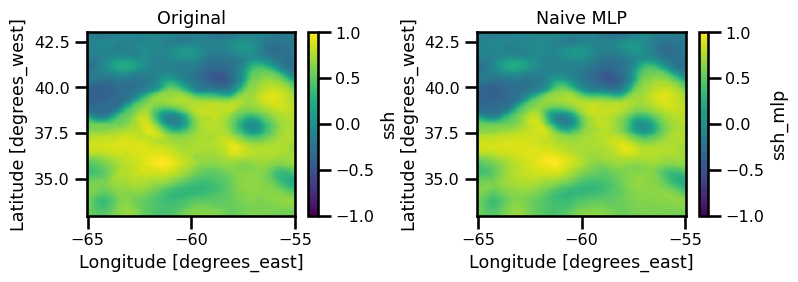

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

```python
class FftMseLoss(object):
    """
    loss function in Fourier space

    June 2022, F.Alesiani
    """
    def __init__(self, reduction='mean'):
        super(FftMseLoss, self).__init__()
        #Dimension and Lp-norm type are postive
        self.reduction = reduction
    def __call__(self, x, y, flow=None,fhigh=None, eps=1e-20):
        num_examples = x.size()[0]
        others_dims = x.shape[1:-2]
        for d in others_dims:
            assert (d>1), "we expect the dimension to be the same and greater the 1"
        # print(others_dims)
        dims = list(range(1,len(x.shape)-1))
        xf = torch.fft.fftn(x,dim=dims)
        yf = torch.fft.fftn(y,dim=dims)
        if flow is None: flow = 0
        if fhigh is None: fhigh = np.max(xf.shape[1:])

        if len(others_dims) ==1:
            xf = xf[:,flow:fhigh]
            yf = yf[:,flow:fhigh]        
        if len(others_dims) ==2:
            xf = xf[:,flow:fhigh,flow:fhigh]
            yf = yf[:,flow:fhigh,flow:fhigh]
        if len(others_dims) ==3:
            xf = xf[:,flow:fhigh,flow:fhigh,flow:fhigh]
            yf = yf[:,flow:fhigh,flow:fhigh,flow:fhigh]
        if len(others_dims) ==4:
            xf = xf[:,flow:fhigh,flow:fhigh,flow:fhigh,flow:fhigh]
            yf = yf[:,flow:fhigh,flow:fhigh,flow:fhigh,flow:fhigh]
        _diff = xf - yf
        _diff = _diff.reshape(num_examples,-1).abs()**2
        if self.reduction in ['mean']:
            return torch.mean(_diff).abs()
        if self.reduction in ['sum']:
            return torch.sum(_diff).abs()
        return _diff.abs()
```

```python
    if len(idxs) == 4:  # 1D
        nx = idxs[2]
        pred_F = torch.fft.rfft(pred, dim=2)
        target_F = torch.fft.rfft(target, dim=2)
        _err_F = torch.sqrt(torch.mean(torch.abs(pred_F - target_F) ** 2, axis=0)) / nx * Lx
    if len(idxs) == 5:  # 2D
        pred_F = torch.fft.fftn(pred, dim=[2, 3])
        target_F = torch.fft.fftn(target, dim=[2, 3])
        nx, ny = idxs[2:4]
        _err_F = torch.abs(pred_F - target_F) ** 2
        err_F = torch.zeros([nb, nc, min(nx // 2, ny // 2), nt]).to(device)
        for i in range(nx // 2):
            for j in range(ny // 2):
                it = mt.floor(mt.sqrt(i ** 2 + j ** 2))
                if it > min(nx // 2, ny // 2) - 1:
                    continue
                err_F[:, :, it] += _err_F[:, :, i, j]
        _err_F = torch.sqrt(torch.mean(err_F, axis=0)) / (nx * ny) * Lx * Ly
```

In [ ]:
def fft_mse_1D_red():
    
    return loss

In [78]:
xrda.ssh.data.shape

(1, 201, 201)

In [60]:
loss_mlp = fft_mse_1D(xrda.ssh.data.ravel(), xrda.ssh_mlp.data.ravel())
loss_pre = fft_mse_1D(xrda.ssh.data.ravel(), xrda.ssh_pre.data.ravel())

loss_mlp, loss_pre

(-4409.288-7171.893j) (15479.882+0j)
(-4409.288-7171.893j) (15479.882+0j)


(Array(8.443195, dtype=float32), Array(8403.085, dtype=float32))

In [55]:

ssh_f = np.fft.fftn(xrda.ssh.data)
ssh_mlp_f = np.fft.fftn(xrda.ssh_mlp.data)
ssh_pre_f = np.fft.fftn(xrda.ssh_pre.data)

ssh_f.shape, ssh_mlp_f.shape, ssh_pre_f.shape

((1, 201, 201), (1, 201, 201), (1, 201, 201))

In [64]:
flow = 0
fhigh = np.max(ssh_f.shape[1:])
flow, fhigh

(0, 201)

In [71]:
ssh_f_red = ssh_f[:, flow:fhigh, flow:fhigh]
ssh_mlp_f_red = ssh_mlp_f[:, flow:fhigh, flow:fhigh]
ssh_pre_f_red = ssh_pre_f[:, flow:fhigh, flow:fhigh]
ssh_f_red.shape, ssh_mlp_f_red.shape, ssh_pre_f_red.shape

((1, 201, 201), (1, 201, 201), (1, 201, 201))

In [73]:
diff_mlp = ssh_f_red - ssh_mlp_f_red
diff_pre = ssh_f_red - ssh_pre_f_red

In [75]:
np.abs(np.mean(diff_mlp))

0.020105064149144113

In [76]:
np.abs(np.mean(diff_pre))

0.5708498952434036

### Random Fourier Features

$$
\boldsymbol{\phi}(\mathbf{x}) = 
\sqrt{\frac{\sigma^2}{N_{RF}}}
\left[
\cos(\boldsymbol{\Omega}\mathbf{x}),
\sin(\boldsymbol{\Omega}\mathbf{x})
\right]
$$

where $\boldsymbol{\Omega}$ is a random matrix sampled from a Gaussian distribution.

$$
\begin{aligned}
p(\Omega)&\sim\mathcal{N}(0,\boldsymbol{\Lambda}^{-1}_D) \\
\boldsymbol{\Lambda}_D &= \text{diag}
\left(\lambda_1, \lambda_2, \ldots, \lambda_D\right)
\end{aligned}
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [ ]:
# load config
model_config = OmegaConf.load("./configs/model.yaml")

# instantiate
model_ffn = hydra.utils.instantiate(model_config.ffn)

# test output
out = model_ffn(x=x_init[0], t=t_init[0])
assert out.shape == y_init[0].shape

# test output (batched)
out_batch = jax.vmap(model_ffn, in_axes=(0, 0))(x_init, t_init)
assert out_batch.shape == y_init.shape

In [ ]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model_ffn,
    optimizer,
    seed=seed,
    debug=debug,
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir,
)

train_more = False

In [ ]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

In [ ]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")
except:
    pass

In [ ]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

In [ ]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

In [ ]:
out, metrics = trainer.test_model(dm.test_dataloader())

metrics

In [ ]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_rff_ssh.ckpt")

In [ ]:
all_metrics = pd.concat(
    [
        all_metrics,
        pd.DataFrame(
            data=[["rff", metrics["loss"], metrics["psnr"]]],
            columns=["model", "MSE", "PSNR"],
        ),
    ]
)

In [ ]:
all_metrics

In [ ]:
xrda["ssh_rfe"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)
xrda["ssh_rfe"].attrs["standard_name"] = "Sea Surface Height"

In [ ]:
ssh_fn_rff = trainer.model

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

xrda.ssh_rfe.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="viridis")
ax[2].set(title="Fourier Features")


plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [ ]:
# load config
model_config = OmegaConf.load("./configs/model.yaml")

# instantiate
model_siren = hydra.utils.instantiate(model_config.siren)

# test output
out = model_siren(x=x_init[0], t=t_init[0])
assert out.shape == y_init[0].shape

# test output (batched)
out_batch = jax.vmap(model_siren, in_axes=(0, 0))(x_init, t_init)
assert out_batch.shape == y_init.shape

In [ ]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model_siren,
    optimizer,
    seed=seed,
    debug=debug,
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir,
)

train_more = False

In [ ]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

In [ ]:
try:
    trainer.load_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")
except:
    pass

In [ ]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

In [ ]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

In [ ]:
out, metrics = trainer.test_model(dm.test_dataloader())

metrics

In [ ]:
all_metrics = pd.concat(
    [
        all_metrics,
        pd.DataFrame(
            data=[["siren", metrics["loss"], metrics["psnr"]]],
            columns=["model", "MSE", "PSNR"],
        ),
    ]
)

In [ ]:
all_metrics

In [ ]:
if train_more:
    trainer.save_model("./checkpoints/checkpoint_model_siren_ssh.ckpt")

In [ ]:
xrda["ssh_siren"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)
xrda["ssh_siren"].attrs["standard_name"] = "Sea Surface Height"

In [ ]:
ssh_fn_siren = trainer.model

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

xrda.ssh_rfe.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="viridis")
ax[2].set(title="Fourier Features")

xrda.ssh_siren.isel(time=0).plot.pcolormesh(ax=ax[3], cmap="viridis")
ax[3].set(title="Siren")


plt.tight_layout()
plt.show()

## Derived Variables

In [ ]:
# create function
ssh_fn: tp.Callable = ssh_fn_siren  # ssh_fn_mlp #  ssh_fn_rff #

**Domain**

$$
\begin{aligned}
\text{Spatial}[m]: && 
\mathbf{x} &\in\Omega\in\mathbb{R}^{D}
\end{aligned}
$$

$$
\mathbf{x} = 
\begin{bmatrix}
\text{lat} \\ \text{lon}
\end{bmatrix}
$$







**Sea Surface Height**

The proper sea surface height equation is given by:

$$
\begin{aligned}
\text{Sea Surface Height}[m]: && 
\eta &=\boldsymbol{\eta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\eta}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

Here, we learned a parameterized function, $\boldsymbol{f_\theta}(\cdot)$, as a substitute for the true field. This is given by:

$$
\begin{aligned}
\boldsymbol{f} &=\boldsymbol{f}(\vec{\mathbf{x}},t;\boldsymbol{\theta})
&& && 
\boldsymbol{f}: \boldsymbol{\Omega}\times\boldsymbol{T}\times\boldsymbol{\Theta}\rightarrow\mathbb{R}
\end{aligned}
$$

In [ ]:
# create FAST batched function
ssh_fn_batch: tp.Callable = jax.vmap(ssh_fn, in_axes=(0, 0))

# make it FAST!
ssh_fn_batch: tp.Callable = jax.jit(ssh_fn_batch, backend="cpu")

# predict on the batch of coordinates
ssh: Array = ssh_fn_batch(dm.ds_test[:]["spatial"], dm.ds_test[:]["temporal"])

In [ ]:
def make_vmap_st(f):
    return jax.vmap(f, in_axes=(0, 0))


def make_jit_cpu(f):
    return jax.jit(f, backend="cpu")

In [ ]:
# create data array
xr_ssh: xr.Dataset = dm.data_to_df(ssh).to_xarray().ssh

# quick plot
xr_ssh.isel(time=0).plot.pcolormesh(cmap="viridis")

**INTERLUDE**: We can query wherever we want!

In [ ]:
num_x = 500
num_y = 500
num_t = 1
x_coords = np.linspace(-0.5, 0.5, num_x)
y_coords = np.linspace(-0.5, 0.5, num_y)
t_coords = np.linspace(0, 0, num_t)

In [ ]:
import einops

# create coordinates
XYT = np.meshgrid(x_coords, y_coords, t_coords, indexing="ij")

XYT = np.stack(XYT, axis=-1)

# XY, T = XYT[..., :-1], XYT[..., -1]

XYT = einops.rearrange(XYT, "H W T D -> (H W T) D")

XY, T = XYT[..., :-1], XYT[..., -1]
XY.shape, T.shape

In [ ]:
out = ssh_fn_batch(XY, T)
print(out.shape)
out = einops.rearrange(out, "(H W T) D -> H W T D", H=num_x, W=num_y, T=num_t)
out.shape

In [ ]:
%matplotlib inline
plt.scatter(XY[..., 1], XY[..., 0], c=out.squeeze())

### Stream Function

$$
\begin{aligned}
\text{Stream Function }[ms^{-1}]: && 
\psi &=\boldsymbol{\psi}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$


$$
\psi = \frac{g}{f_0}\eta
$$


In [ ]:
from jejeqx._src.transforms.xarray.geostrophic import calculate_coriolis
from metpy.constants import earth_gravity

f0 = calculate_coriolis(xrda.lat)
print(f"Coriolis Parameter:", f0.data)
print(f"Earth Gravity:", earth_gravity)

In [ ]:
f0: Array = jnp.asarray(calculate_coriolis(xrda.lat).data.magnitude)
g: Array = jnp.asarray(earth_gravity.magnitude)

In [ ]:
def create_streamfn(f: tp.Callable, f0: float = 1e-5, g: float = 9.81) -> tp.Callable:
    def sfn(x: Array, t: Array) -> Array:
        return (g / f0) * f(x, t)

    return sfn

In [ ]:
psi_fn = create_streamfn(ssh_fn)

# create FAST Batched Function
psi_fn_batch = make_jit_cpu(make_vmap_st(psi_fn))

In [ ]:
# make predictions
psi = psi_fn_batch(dm.ds_test[:]["spatial"], dm.ds_test[:]["temporal"])

In [ ]:
# create xarray dataset
xrda["psi"] = (g / f0) * xrda.ssh
xrda["psi_ad"] = (("time", "lat", "lon"), dm.data_to_df(psi).to_xarray().ssh.data)

# demo plot
xrda["psi_ad"].isel(time=0).plot.pcolormesh(cmap="viridis")

### Velocities

$$
\begin{aligned}
\text{U Velocity}[ms^{-1}]: && 
u &=\boldsymbol{u}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R} \\
\text{V Velocity}[ms^{-1}]: && 
v &=\boldsymbol{v}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\begin{aligned}
u = -\frac{\partial \psi}{\partial y} && 
v = \frac{\partial \psi}{\partial x}
\end{aligned}
$$

In [ ]:
def create_gradient_fn(f: tp.Callable) -> tp.Callable:
    def fn(x: Array, t: Array) -> Array:
        return jax.jacfwd(f)(x, t).squeeze()

    return fn


def uv_velocity(grad_psi: Array) -> tp.Tuple[Array, Array]:
    dpsi_x, dpsi_y = jnp.split(grad_psi, 2, axis=-1)

    u = -dpsi_y
    v = dpsi_x
    return u, v

In [ ]:
grad_psi_fn = create_gradient_fn(psi_fn)

grad_psi_fn_batched = make_jit_cpu(make_vmap_st(grad_psi_fn))

In [ ]:
# make predictions
grad_psi = grad_psi_fn_batched(dm.ds_test[:]["spatial"], dm.ds_test[:]["temporal"])


# parse to get velocity
u, v = uv_velocity(grad_psi)

In [ ]:
# create xarray dataset
xrda["u_ad"] = (("time", "lat", "lon"), dm.data_to_df(u).to_xarray().ssh.data)
xrda["v_ad"] = (("time", "lat", "lon"), dm.data_to_df(v).to_xarray().ssh.data)

xrda["ke_ad"] = np.hypot(xrda["u_ad"], xrda["v_ad"])

In [ ]:
fig, ax = plt.subplots()

xrda["ke_ad"].isel(time=0).plot.pcolormesh(ax=ax, cmap="YlGnBu_r")

plt.tight_layout()
plt.show()

#### Finite Difference 

So we can also do this in discrete space as well. Meaning, we can take the derivative of the field we are interested in.
$$
\frac{\partial \psi}{\partial x}= D[\psi](\vec{\mathbf{x}})
$$

We have many different types, e.g. central difference, forwards difference and backwards difference.

In [ ]:
import jejeqx._src.transforms.xarray.geostrophic as geocalc

In [ ]:
xrda = geocalc.calculate_velocities_sf(xrda, "psi")
xrda = geocalc.calculate_kinetic_energy(xrda, ["u", "v"])
xrda

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

xrda["ke_ad"].isel(time=0).plot.pcolormesh(ax=ax[0], cmap="YlGnBu_r")
ax[0].set(title="Auto-Differentiation")
xrda["ke"].isel(time=0).plot.pcolormesh(ax=ax[1], cmap="YlGnBu_r")
ax[1].set(title="Finite Difference")

plt.tight_layout()
plt.show()

## Relative Vorticity

Somtimes called the *vertical vorticity*.



$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) - 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2}+ \frac{\partial^2 \psi}{\partial y^2}\\
\zeta &=\nabla^2\psi
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

Note: This is closely related to the geostrophic eqns:

$$
\begin{aligned}
\text{Relative Vorticity }[s^{-1}]: && 
\zeta &=\boldsymbol{\zeta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\xi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\zeta = \nabla^2\psi
$$


In [ ]:
def create_laplacian_fn(f: tp.Callable) -> tp.Callable:
    def fn(x: Array) -> Array:
        # return jax.jacfwd(jax.jacrev(f))(x)
        H = jax.hessian(f)
        L = jnp.diagonal(H(x)[0])
        return jnp.sum(L, keepdims=True)

    return fn

In [ ]:
rvort_fn = create_laplacian_fn(psi_fn)
rvort_fn(x_init[0])

rvort_fn_batched = jax.jit(jax.vmap(rvort_fn, in_axes=(0, 0)), backend="cpu")

In [ ]:
rvort = rvort_fn_batched(dm.ds_test[:]["spatial"], dm.ds_test[:]["temporal"])

In [ ]:
# create xarray dataset
xrda["rvort"] = dm.data_to_df(rvort).to_xarray().ssh

In [ ]:
import finitediffx as fdx

method = "central"
order = 1
step_size = 1
accuracy = 1

dv_dx = dfdx(xrda["v_fd"].data)

du_dy = dfdy(xrda["u_fd"].data)

In [ ]:
xrda["rvort_fd"] = (("time", "lat", "lon"), dv_dx - du_dy)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

xrda["rvort"].isel(time=0).plot.pcolormesh(ax=ax[0], cmap="RdBu_r")
ax[0].set(title="Auto-Differentiation")
xrda["rvort_fd"].isel(time=0).plot.pcolormesh(ax=ax[1], cmap="RdBu_r")
ax[1].set(title="Finite Difference")

plt.tight_layout()
plt.show()

In [ ]:
import common_utils as cutils

In [ ]:
ds_rfe = cutils.calculate_physical_quantities(xrda.ssh_rfe)
ds_natl60 = cutils.calculate_physical_quantities(xrda.ssh)
ds_mlp = cutils.calculate_physical_quantities(xrda.ssh_mlp)
ds_siren = cutils.calculate_physical_quantities(xrda.ssh_siren)

In [ ]:
def rmse_da(da, da_ref, dim):
    return ((da - da_ref) ** 2).mean(dim=dim) ** 0.5


def nrmse_da(da, da_ref, dim):
    rmse = rmse_da(da=da, da_ref=da_ref, dim=dim)
    std = (da_ref**2).mean(dim=dim) ** 0.5
    return 1.0 - (rmse / std).data.magnitude

In [ ]:
import pandas as pd

dims = ["lat", "lon"]

results_df = pd.DataFrame()

for imodel, iname in zip([ds_mlp, ds_rfe, ds_siren], ["MLP", "RFE", "SIREN"]):
    for ivar in imodel:
        error = nrmse_da(imodel[ivar], ds_natl60[ivar], dims)

        ires_df = pd.DataFrame(
            data=[[iname, ivar, error.item()]],
            columns=[
                "model",
                "variable",
                "nrmse",
            ],
        )

        results_df = pd.concat([ires_df, results_df.loc[:]], axis=0)

In [ ]:
results_df.head()

In [ ]:
results_df.loc[results_df["variable"] == "ke"].sort_values("nrmse")

In [ ]:
fig, ax = cutils.plot_analysis_vars(
    [
        ds_natl60.isel(time=0),
        ds_mlp.isel(time=0),
        ds_rfe.isel(time=0),
        ds_siren.isel(time=0),
    ],
    figsize=(30, 30),
)
# fig.suptitle("NATL60   |   MLP   |      RFE     |      SIREN"),
plt.show()

In [ ]:
#

In [ ]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rfe = cutils.calculate_isotropic_psd(ds_rfe)
ds_psd_mlp = cutils.calculate_isotropic_psd(ds_mlp)
ds_psd_siren = cutils.calculate_isotropic_psd(ds_siren)

In [ ]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_mlp, ds_psd_rfe, ds_psd_siren],
    ["NATL60", "MLP", "RFE", "SIREN"],
)
plt.show()

In [ ]:
ds_rfe_scores = cutils.calculate_isotropic_psd_score(ds_rfe, ds_natl60)
ds_mlp_scores = cutils.calculate_isotropic_psd_score(ds_mlp, ds_natl60)
ds_siren_scores = cutils.calculate_isotropic_psd_score(ds_siren, ds_natl60)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(
    columns=["model", "variable", "wavelength [km]", "wavelength [degree]"]
)

for iscore, imodel in zip(
    [ds_mlp_scores, ds_rfe_scores, ds_siren_scores], ["MLP", "RFE", "SIREN"]
):
    for ivar in iscore:
        resolved_spatial_scale = iscore[ivar].attrs["resolved_scale_space"] / 1e3

        ires_df = pd.DataFrame(
            data=[[imodel, ivar, resolved_spatial_scale, resolved_spatial_scale / 111]],
            columns=["model", "variable", "wavelength [km]", "wavelength [degree]"],
        )

        results_df = pd.concat([ires_df, results_df.loc[:]], axis=0)

In [ ]:
results_df.head()

In [ ]:
results_df.loc[results_df["variable"] == "strain"].sort_values("wavelength [km]")

In [ ]:
cutils.plot_analysis_psd_iso_score(
    [ds_mlp_scores, ds_rfe_scores, ds_siren_scores],
    ["MLP", "RFE", "SIREN"],
    ["b", "orange", "green"],
)
plt.show()